In [ ]:
# ============================================================================
# SECTION 1: IMPORTS & SETUP
# ============================================================================
import os
import sys
import pickle
import time
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from torchvision.utils import make_grid
from torchvision.transforms.functional import to_pil_image
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Qiskit imports for quantum head
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.primitives import Sampler
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.connectors import TorchConnector

# Interpretability and logging
from torchcam.cams import GradCAM
from torchcam.utils import overlay_mask
import wandb

# Install required packages
!pip install -q kagglehub qiskit qiskit_machine_learning wandb torchcam > /dev/null 2>&1

print("✅ All imports completed successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

✅ All imports completed successfully!
PyTorch version: 2.9.0+cu126
CUDA available: True


In [14]:
# ============================================================================
# SECTION 2: DATASET CLASS
# ============================================================================
import kagglehub

class DiabeticRetinopathyDataset(Dataset):
    def __init__(self, dataset_type='sovitrath', mode='train', transform=None):
        super().__init__()
        self.dataset_type = dataset_type
        self.mode = mode
        self.transform = transform

        if dataset_type == 'sovitrath':
            self.load_sovitrath_dataset()
        else:
            self.load_tanlikesmath_dataset()

        print(f"✅ Loaded {len(self.image_paths)} images from {dataset_type} ({mode} set)")

    def load_sovitrath_dataset(self):
        try:
            path = kagglehub.dataset_download("sovitrath/diabetic-retinopathy-224x224-gaussian-filtered")
            print(f"📂 Dataset downloaded to: {path}")

            base_path = os.path.join(path, "gaussian_filtered_images", "gaussian_filtered_images")
            self.classes = ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR']
            self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

            self.image_paths = []
            self.labels = []

            for class_name in self.classes:
                class_path = os.path.join(base_path, class_name)
                if os.path.exists(class_path):
                    for img_name in os.listdir(class_path):
                        if img_name.endswith(('.png', '.jpg', '.jpeg')):
                            self.image_paths.append(os.path.join(class_path, img_name))
                            self.labels.append(self.class_to_idx[class_name])

        except Exception as e:
            print(f"⚠️ Error loading Sovitrath dataset: {e}")
            self.create_mock_dataset()

    def load_tanlikesmath_dataset(self):
        try:
            path = kagglehub.dataset_download("tanlikesmath/diabetic-retinopathy-resized")
            print(f"📂 Dataset downloaded to: {path}")

            base_path = os.path.join(path, "resized_train", "resized_train")
            labels_path = os.path.join(path, "resized_train", "trainLabels.csv")

            labels_df = pd.read_csv(labels_path)
            self.classes = ['0', '1', '2', '3', '4']
            self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

            self.image_paths = []
            self.labels = []

            for _, row in labels_df.iterrows():
                img_name = row['image'] + '.jpeg'
                img_path = os.path.join(base_path, img_name)
                if os.path.exists(img_path):
                    self.image_paths.append(img_path)
                    self.labels.append(int(row['level']))

        except Exception as e:
            print(f"⚠️ Error loading Tanlikesmath dataset: {e}")
            self.create_mock_dataset()

    def create_mock_dataset(self):
        print("📝 Creating mock dataset for testing...")
        self.classes = ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.image_paths = [f"dummy_{i}.jpg" for i in range(500)]
        self.labels = [i % 5 for i in range(500)]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            img_path = self.image_paths[idx]
            if img_path.startswith("dummy_"):
                image = Image.fromarray(np.random.randint(0, 255, (224, 224, 3), dtype=np.uint8))
            else:
                image = Image.open(img_path).convert('RGB')

            if self.transform:
                image = self.transform(image)

            label = self.labels[idx]
            return image, label, img_path

        except Exception as e:
            print(f"⚠️ Error loading image {img_path}: {e}")
            dummy_image = torch.randn(3, 224, 224)
            dummy_label = 0
            return dummy_image, dummy_label, "dummy_path"

print("✅ Dataset class defined successfully!")

✅ Dataset class defined successfully!


In [ ]:
# ============================================================================
# SECTION 3: MODEL ARCHITECTURE (UPDATED WITH LATENCY TRACKING AND STAGED SUPPORT)
# ============================================================================
class VisionEncoder(nn.Module):
    def __init__(self, encoder_type='vit', pretrained=True):
        super().__init__()
        self.encoder_type = encoder_type

        if encoder_type == 'vit':
            self.encoder = models.vit_b_16(pretrained=pretrained)
            self.encoder.heads = nn.Identity()
            self.projection = nn.Linear(768, 2048)
        else:
            resnet = models.resnet50(pretrained=pretrained)
            self.encoder = nn.Sequential(
                resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool,
                resnet.layer1, resnet.layer2, resnet.layer3, resnet.layer4,
                nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten()
            )
            self.projection = nn.Identity()

    def forward(self, x):
        features = self.encoder(x)
        if self.encoder_type == 'vit':
            features = self.projection(features)
        return features

class CompressionModule(nn.Module):
    def __init__(self, input_dim=2048, compressed_dim=30):
        super().__init__()
        self.compressor = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, compressed_dim)
        )

    def forward(self, x):
        return self.compressor(x)

class ClassicalHeadA(nn.Module):
    def __init__(self, input_dim=2048, num_classes=5):
        super().__init__()
        self.head = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.head(x)

class ClassicalHeadB(nn.Module):
    def __init__(self, input_dim=30, num_classes=5):
        super().__init__()
        self.head = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        return self.head(x)

class QuantumClassificationHead(nn.Module):
    """Quantum classification head backed by a Qiskit SamplerQNN."""
    def __init__(self, input_dim=32, num_classes=5, num_qubits=4, shots=1024):
        super().__init__()
        self.num_qubits = num_qubits
        self.num_classes = num_classes
        self.q_device = torch.device("cpu")
        self.input_projection = nn.Linear(input_dim, num_qubits)

        feature_map = ZZFeatureMap(num_qubits, reps=2)
        ansatz = RealAmplitudes(num_qubits, reps=2)
        circuit = feature_map.compose(ansatz)

        sampler = Sampler(options={"shots": shots})
        self.qnn = SamplerQNN(
            sampler=sampler,
            circuit=circuit,
            input_params=feature_map.parameters,
            weight_params=ansatz.parameters,
            sparse=False,
            input_gradients=True
        )

        initial_weights = torch.zeros(self.qnn.num_weights, dtype=torch.double)
        self.q_layer = TorchConnector(self.qnn, initial_weights=initial_weights)

        output_dim = 2 ** num_qubits
        self.post_process = nn.Sequential(
            nn.Linear(output_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        projected = self.input_projection(x)
        projected_cpu = projected.to(self.q_device, dtype=torch.double)
        quantum_raw = self.q_layer(projected_cpu)
        quantum_raw = quantum_raw.to(dtype=torch.float32)
        target_device = projected.device
        if any(True for _ in self.post_process.parameters()):
            target_device = next(self.post_process.parameters()).device
        quantum_raw = quantum_raw.to(target_device)
        logits = self.post_process(quantum_raw)
        return logits

class DynamicEnsemble(nn.Module):
    """Dynamic ensemble with trainable weight parameters supporting head masking."""
    def __init__(self, num_heads=3, init_temp=1.0):
        super().__init__()
        self.num_heads = num_heads
        self.base_weights = nn.Parameter(torch.ones(num_heads) / num_heads)
        self.temperature = nn.Parameter(torch.tensor(init_temp))
        self.uncertainty_scales = nn.Parameter(torch.ones(num_heads))
        print("✅ DynamicEnsemble initialized with trainable weights")

    def forward(self, head_outputs, uncertainties=None, active_mask=None):
        if active_mask is None:
            mask = torch.ones(len(head_outputs), device=head_outputs[0].device)
        else:
            mask = active_mask.to(head_outputs[0].device).float()

        weights = F.softmax(self.base_weights / self.temperature, dim=0)
        weights = weights * mask
        if weights.sum() <= 0:
            weights = torch.ones_like(weights) * mask
        weights = weights / (weights.sum() + 1e-8)

        if uncertainties is not None and self.training:
            if uncertainties.dim() == 1:
                uncertainties = uncertainties.unsqueeze(0)
            scaled_uncertainties = uncertainties * self.uncertainty_scales.unsqueeze(0)
            confidence = 1.0 / (scaled_uncertainties + 1e-8)
            batch_confidence = confidence.mean(dim=0)
            confidence_weights = F.softmax(batch_confidence, dim=0)
            with torch.no_grad():
                predictions = torch.stack([torch.argmax(out, dim=1) for out in head_outputs], dim=1)
                predictions_float = predictions.float()
                max_vals, _ = predictions_float.max(dim=1)
                min_vals, _ = predictions_float.min(dim=1)
                agreement_mask = (max_vals == min_vals).float()
                agreement = agreement_mask.mean()
            uncertainty_weight = 0.7 * (1 - agreement) + 0.3
            weights = (1 - uncertainty_weight) * weights + uncertainty_weight * confidence_weights

        weights = weights * mask
        if weights.sum() <= 0:
            weights = mask / (mask.sum() + 1e-8)
        weights = weights / (weights.sum() + 1e-8)

        if not self.training:
            weights = weights.detach()

        final_output = None
        for idx, (w, out) in enumerate(zip(weights, head_outputs)):
            if mask[idx] > 0:
                final_output = out * w if final_output is None else final_output + w * out

        if final_output is None:
            final_output = head_outputs[0]
        return final_output, weights

class ClassicalDRModel(nn.Module):
    """Classical + Quantum hybrid model with dynamic ensemble."""
    def __init__(self, encoder_type='vit', num_classes=5, compressed_dim=30, quantum_int=True):
        super().__init__()
        self.vision_encoder = VisionEncoder(encoder_type=encoder_type)
        self.compression = CompressionModule(input_dim=2048, compressed_dim=compressed_dim)
        self.classical_head_a = ClassicalHeadA(input_dim=2048, num_classes=num_classes)
        self.classical_head_b = ClassicalHeadB(compressed_dim, num_classes=num_classes)
        self.quantum_enabled = quantum_int
        if quantum_int:
            self.quantum_head = QuantumClassificationHead(input_dim=compressed_dim, num_classes=num_classes)
        else:
            self.quantum_head = None
        self.ensemble = DynamicEnsemble(num_heads=3)
        self.num_classes = num_classes
        self.compressed_dim = compressed_dim
        self.track_latencies = False
        self.head_order = ['classical_a', 'classical_b', 'quantum']
        print("✅ Model architecture with quantum head defined successfully!")

    def enable_latency_tracking(self, enabled=True):
        self.track_latencies = enabled

    def forward(self, x, return_all=True, active_mask=None, track_latency=None):
        if track_latency is not None:
            self.track_latencies = track_latency
        mask_tensor = None
        if active_mask is not None:
            mask_tensor = torch.as_tensor(active_mask, device=x.device, dtype=torch.float32)
        latencies = {}
        start = time.perf_counter()
        latent_features = self.vision_encoder(x)
        latencies['encoder'] = time.perf_counter() - start

        start = time.perf_counter()
        compressed_features = self.compression(latent_features)
        latencies['compression'] = time.perf_counter() - start

        head_outputs = []
        start = time.perf_counter()
        output_a = self.classical_head_a(latent_features)
        latencies['classical_a'] = time.perf_counter() - start
        head_outputs.append(output_a)

        start = time.perf_counter()
        output_b = self.classical_head_b(compressed_features)
        latencies['classical_b'] = time.perf_counter() - start
        head_outputs.append(output_b)

        if self.quantum_enabled and self.quantum_head is not None:
            start = time.perf_counter()
            output_c = self.quantum_head(compressed_features)
            latencies['quantum'] = time.perf_counter() - start
        else:
            output_c = torch.zeros_like(output_b)
            latencies['quantum'] = 0.0
        head_outputs.append(output_c)

        with torch.no_grad():
            prob_a = F.softmax(output_a, dim=1)
            prob_b = F.softmax(output_b, dim=1)
            prob_c = F.softmax(output_c, dim=1)
            uncertainties = torch.tensor([
                1.0 - prob_a.max(dim=1)[0].mean(),
                1.0 - prob_b.max(dim=1)[0].mean(),
                1.0 - prob_c.max(dim=1)[0].mean()
            ], device=x.device)

        final_output, ensemble_weights = self.ensemble(
            head_outputs, uncertainties, active_mask=mask_tensor
        )
        latencies['ensemble'] = 0.0

        if return_all:
            return {
                'latent_features': latent_features,
                'compressed_features': compressed_features,
                'output_a': output_a,
                'output_b': output_b,
                'output_c': output_c,
                'final_output': final_output,
                'ensemble_weights': ensemble_weights,
                'uncertainties': uncertainties,
                'latencies': latencies,
                'active_mask': mask_tensor
            }
        return final_output

    def compute_losses(self, outputs, targets, loss_weights=None):
        if loss_weights is None:
            loss_weights = {
                'classical_a': 1.0,
                'classical_b': 1.0,
                'quantum': 1.0,
                'ensemble': 0.5
            }

        losses = {}
        total_loss = 0.0

        if loss_weights.get('classical_a', 0.0) > 0:
            loss_a = F.cross_entropy(outputs['output_a'], targets)
            total_loss += loss_weights['classical_a'] * loss_a
            losses['loss_a'] = loss_a
        else:
            losses['loss_a'] = torch.tensor(0.0, device=targets.device)

        if loss_weights.get('classical_b', 0.0) > 0:
            loss_b = F.cross_entropy(outputs['output_b'], targets)
            total_loss += loss_weights['classical_b'] * loss_b
            losses['loss_b'] = loss_b
        else:
            losses['loss_b'] = torch.tensor(0.0, device=targets.device)

        if loss_weights.get('quantum', 0.0) > 0:
            loss_c = F.cross_entropy(outputs['output_c'], targets)
            total_loss += loss_weights['quantum'] * loss_c
            losses['loss_c'] = loss_c
        else:
            losses['loss_c'] = torch.tensor(0.0, device=targets.device)

        if loss_weights.get('ensemble', 0.0) > 0:
            ensemble_loss = F.cross_entropy(outputs['final_output'], targets)
            total_loss += loss_weights['ensemble'] * ensemble_loss
            losses['ensemble_loss'] = ensemble_loss
        else:
            losses['ensemble_loss'] = torch.tensor(0.0, device=targets.device)

        losses['total_loss'] = total_loss
        return losses

    def extract_compressed_features(self, x):
        with torch.no_grad():
            latent_features = self.vision_encoder(x)
            compressed_features = self.compression(latent_features)
        return compressed_features

✅ Model architecture defined successfully!


In [ ]:
# ============================================================================
# SECTION 4: TRAINING UTILITIES
# ============================================================================
class EarlyStopping:
    def __init__(self, patience=7, delta=0, verbose=False):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'⏳ EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

def compute_accuracy(outputs, targets):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == targets).sum().item()
    total = targets.size(0)
    return correct / total

IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
IMAGENET_STD = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

def tensor_to_numpy_image(tensor):
    img = tensor.detach().cpu()
    if img.dim() == 3 and img.size(0) == 3:
        img = img * IMAGENET_STD + IMAGENET_MEAN
    img = torch.clamp(img, 0, 1)
    pil_img = to_pil_image(img)
    return np.array(pil_img)

def create_confusion_plot(cm, class_names, title):
    fig, ax = plt.subplots(figsize=(5, 4))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    ax.set_title(title)
    plt.tight_layout()
    return fig

def create_head_confidence_figure(image_tensor, head_probabilities, class_names, title):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].imshow(tensor_to_numpy_image(image_tensor))
    axes[0].axis('off')
    axes[0].set_title('Input')

    x = np.arange(len(class_names))
    width = 0.25
    for idx, (head_name, probs) in enumerate(head_probabilities.items()):
        axes[1].bar(x + idx * width, probs, width=width, label=head_name)
    axes[1].set_xticks(x + width)
    axes[1].set_xticklabels(class_names, rotation=45, ha='right')
    axes[1].set_ylim(0, 1)
    axes[1].set_ylabel('Confidence')
    axes[1].set_title(title)
    axes[1].legend()
    axes[1].grid(True, axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    return fig

def generate_saliency_overlay(model, image_tensor, class_idx, device, active_mask):
    try:
        model.eval()
        with torch.enable_grad():
            input_tensor = image_tensor.unsqueeze(0).to(device).requires_grad_(True)
            outputs = model(input_tensor, return_all=True, active_mask=active_mask)
            score = outputs['final_output'][0, class_idx]
            model.zero_grad(set_to_none=True)
            score.backward(retain_graph=False)
            gradients = input_tensor.grad.detach().cpu()[0]
        heatmap = gradients.abs().mean(dim=0)
        heatmap = heatmap / (heatmap.max() + 1e-8)
        base_image = tensor_to_numpy_image(image_tensor)
        overlay = overlay_mask(Image.fromarray(base_image), Image.fromarray(np.uint8(heatmap * 255), mode='L'), alpha=0.5)
        fig, ax = plt.subplots(figsize=(4, 4))
        ax.imshow(overlay)
        ax.axis('off')
        ax.set_title('Gradient-based saliency')
        plt.tight_layout()
        return fig
    except Exception as exc:
        print(f"⚠️ Saliency map generation failed: {exc}")
        return None

print("✅ Training utilities and visualization helpers defined successfully!")

✅ Training utilities defined successfully!


In [ ]:
# ============================================================================
# SECTION 5: PHASE 1 TRAINER
# ============================================================================
class Phase1Trainer:
    def __init__(self, model, device='cuda', class_names=None, use_wandb=False,
                 wandb_project="QSight-Care", wandb_run_name=None, wandb_config=None):
        self.model = model.to(device)
        self.device = device
        self.class_names = class_names or [str(i) for i in range(model.num_classes)]
        self.use_wandb = use_wandb
        self.wandb_project = wandb_project
        self.wandb_run_name = wandb_run_name
        self.wandb_config = wandb_config or {}
        self.wandb_run = None
        self.current_stage = 'full'
        self.active_mask = torch.ones(3, device=device)
        self.loss_weights = {
            'classical_a': 1.0,
            'classical_b': 1.0,
            'quantum': 1.0,
            'ensemble': 0.5
        }
        self.history = {
            'train_loss': [], 'val_loss': [],
            'train_acc_a': [], 'val_acc_a': [],
            'train_acc_b': [], 'val_acc_b': [],
            'train_acc_c': [], 'val_acc_c': [],
            'train_acc_ensemble': [], 'val_acc_ensemble': [],
            'ensemble_weights': [],
            'stages': [],
            'val_confusion_a': [],
            'val_confusion_b': [],
            'val_confusion_c': [],
            'val_confusion_ensemble': [],
            'latency_classical_a': [],
            'latency_classical_b': [],
            'latency_quantum': [],
            'latency_ensemble': []
        }
        self.model.enable_latency_tracking(True)

    def _set_requires_grad(self, module, requires_grad):
        if module is None:
            return
        for param in module.parameters():
            param.requires_grad = requires_grad

    def _configure_stage(self, stage):
        self.current_stage = stage
        stage = stage.lower()
        print("=" * 70)
        print(f"⚙️ Configuring stage: {stage.upper()}")
        if stage == 'classical':
            self.active_mask = torch.tensor([1, 1, 0], device=self.device, dtype=torch.float32)
            self.loss_weights = {'classical_a': 1.0, 'classical_b': 1.0, 'quantum': 0.0, 'ensemble': 0.5}
            self._set_requires_grad(self.model.vision_encoder, True)
            self._set_requires_grad(self.model.compression, True)
            self._set_requires_grad(self.model.classical_head_a, True)
            self._set_requires_grad(self.model.classical_head_b, True)
            if hasattr(self.model, 'quantum_head') and self.model.quantum_head is not None:
                self._set_requires_grad(self.model.quantum_head, False)
            self._set_requires_grad(self.model.ensemble, True)
        elif stage == 'quantum':
            self.active_mask = torch.tensor([0, 0, 1], device=self.device, dtype=torch.float32)
            self.loss_weights = {'classical_a': 0.0, 'classical_b': 0.0, 'quantum': 1.0, 'ensemble': 0.5}
            self._set_requires_grad(self.model.vision_encoder, False)
            self._set_requires_grad(self.model.compression, False)
            self._set_requires_grad(self.model.classical_head_a, False)
            self._set_requires_grad(self.model.classical_head_b, False)
            if hasattr(self.model, 'quantum_head') and self.model.quantum_head is not None:
                self._set_requires_grad(self.model.quantum_head, True)
            self._set_requires_grad(self.model.ensemble, True)
        elif stage == 'ensemble':
            self.active_mask = torch.tensor([1, 1, 1], device=self.device, dtype=torch.float32)
            self.loss_weights = {'classical_a': 0.0, 'classical_b': 0.0, 'quantum': 0.0, 'ensemble': 1.0}
            self._set_requires_grad(self.model.vision_encoder, False)
            self._set_requires_grad(self.model.compression, False)
            self._set_requires_grad(self.model.classical_head_a, False)
            self._set_requires_grad(self.model.classical_head_b, False)
            if hasattr(self.model, 'quantum_head') and self.model.quantum_head is not None:
                self._set_requires_grad(self.model.quantum_head, False)
            self._set_requires_grad(self.model.ensemble, True)
        else:
            self.active_mask = torch.tensor([1, 1, 1], device=self.device, dtype=torch.float32)
            self.loss_weights = {'classical_a': 1.0, 'classical_b': 1.0, 'quantum': 1.0, 'ensemble': 0.5}
            self._set_requires_grad(self.model.vision_encoder, True)
            self._set_requires_grad(self.model.compression, True)
            self._set_requires_grad(self.model.classical_head_a, True)
            self._set_requires_grad(self.model.classical_head_b, True)
            if hasattr(self.model, 'quantum_head') and self.model.quantum_head is not None:
                self._set_requires_grad(self.model.quantum_head, True)
            self._set_requires_grad(self.model.ensemble, True)
        print(f"🎯 Active mask: {self.active_mask.tolist()}")
        print(f"🧮 Loss weights: {self.loss_weights}")
        print("=" * 70)

    def _init_wandb_if_needed(self, stage_config):
        if not self.use_wandb:
            return
        if self.wandb_run is None:
            config = {'class_names': self.class_names, **self.wandb_config, **stage_config}
            self.wandb_run = wandb.init(project=self.wandb_project, name=self.wandb_run_name, config=config, reinit=True)

    def _close_wandb(self):
        if self.wandb_run is not None:
            wandb.finish()
            self.wandb_run = None

    def _collect_trainable_parameters(self):
        return [p for p in self.model.parameters() if p.requires_grad]

    def train_epoch(self, train_loader, optimizer, epoch, stage_name):
        self.model.train()
        total_loss = 0.0
        metrics = {'a': 0.0, 'b': 0.0, 'c': 0.0, 'ensemble': 0.0}
        latencies = {'classical_a': 0.0, 'classical_b': 0.0, 'quantum': 0.0, 'ensemble': 0.0}
        epoch_weights = []
        num_batches = 0
        mask = self.active_mask.to(self.device)
        pbar = tqdm(train_loader, desc=f'📚 Epoch {epoch + 1} [{stage_name}] [Train]')
        for images, targets, _ in pbar:
            images, targets = images.to(self.device), targets.to(self.device)
            outputs = self.model(images, return_all=True, active_mask=mask)
            losses = self.model.compute_losses(outputs, targets, self.loss_weights)
            optimizer.zero_grad()
            losses['total_loss'].backward()
            torch.nn.utils.clip_grad_norm_(self._collect_trainable_parameters(), max_norm=1.0)
            optimizer.step()

            acc_a = compute_accuracy(outputs['output_a'], targets) if mask[0] > 0 else float('nan')
            acc_b = compute_accuracy(outputs['output_b'], targets) if mask[1] > 0 else float('nan')
            acc_c = compute_accuracy(outputs['output_c'], targets) if mask[2] > 0 else float('nan')
            acc_ensemble = compute_accuracy(outputs['final_output'], targets)

            metrics['a'] += 0.0 if np.isnan(acc_a) else acc_a
            metrics['b'] += 0.0 if np.isnan(acc_b) else acc_b
            metrics['c'] += 0.0 if np.isnan(acc_c) else acc_c
            metrics['ensemble'] += acc_ensemble
            total_loss += losses['total_loss'].item()
            epoch_weights.append(outputs['ensemble_weights'].detach().cpu().numpy())
            for key in latencies:
                latencies[key] += outputs['latencies'].get(key, 0.0)
            num_batches += 1
            pbar.set_postfix({
                'Loss': f"{losses['total_loss'].item():.4f}",
                'Acc': f"{acc_ensemble:.2%}",
                'W': f"{outputs['ensemble_weights'].detach().cpu().numpy()}"
            })

        if num_batches == 0:
            num_batches = 1
        avg_loss = total_loss / num_batches
        train_metrics = {
            'loss': avg_loss,
            'acc': {
                'a': metrics['a'] / max(num_batches, 1) if mask[0] > 0 else float('nan'),
                'b': metrics['b'] / max(num_batches, 1) if mask[1] > 0 else float('nan'),
                'c': metrics['c'] / max(num_batches, 1) if mask[2] > 0 else float('nan'),
                'ensemble': metrics['ensemble'] / num_batches
            },
            'latencies': {key: latencies[key] / num_batches for key in latencies},
            'ensemble_weights': np.mean(epoch_weights, axis=0) if epoch_weights else np.zeros(3)
        }
        return train_metrics

    def validate(self, val_loader, epoch, stage_name):
        self.model.eval()
        total_loss = 0.0
        metrics = {'a': 0.0, 'b': 0.0, 'c': 0.0, 'ensemble': 0.0}
        latencies = {'classical_a': 0.0, 'classical_b': 0.0, 'quantum': 0.0, 'ensemble': 0.0}
        num_batches = 0
        mask = self.active_mask.to(self.device)
        all_targets = []
        head_predictions = {'a': [], 'b': [], 'c': [], 'ensemble': []}
        sample_visuals = []
        pbar = tqdm(val_loader, desc=f'🔍 Epoch {epoch + 1} [{stage_name}] [Val]')
        with torch.no_grad():
            for batch_idx, (images, targets, paths) in enumerate(pbar):
                images, targets = images.to(self.device), targets.to(self.device)
                outputs = self.model(images, return_all=True, active_mask=mask)
                losses = self.model.compute_losses(outputs, targets, self.loss_weights)

                prob_a = F.softmax(outputs['output_a'], dim=1)
                prob_b = F.softmax(outputs['output_b'], dim=1)
                prob_c = F.softmax(outputs['output_c'], dim=1)
                prob_ensemble = F.softmax(outputs['final_output'], dim=1)

                pred_a = torch.argmax(outputs['output_a'], dim=1)
                pred_b = torch.argmax(outputs['output_b'], dim=1)
                pred_c = torch.argmax(outputs['output_c'], dim=1)
                pred_ensemble = torch.argmax(outputs['final_output'], dim=1)

                acc_a = compute_accuracy(outputs['output_a'], targets) if mask[0] > 0 else float('nan')
                acc_b = compute_accuracy(outputs['output_b'], targets) if mask[1] > 0 else float('nan')
                acc_c = compute_accuracy(outputs['output_c'], targets) if mask[2] > 0 else float('nan')
                acc_ensemble = compute_accuracy(outputs['final_output'], targets)

                metrics['a'] += 0.0 if np.isnan(acc_a) else acc_a
                metrics['b'] += 0.0 if np.isnan(acc_b) else acc_b
                metrics['c'] += 0.0 if np.isnan(acc_c) else acc_c
                metrics['ensemble'] += acc_ensemble
                total_loss += losses['total_loss'].item()
                for key in latencies:
                    latencies[key] += outputs['latencies'].get(key, 0.0)
                num_batches += 1
                all_targets.extend(targets.cpu().numpy().tolist())
                head_predictions['a'].extend(pred_a.cpu().numpy().tolist())
                head_predictions['b'].extend(pred_b.cpu().numpy().tolist())
                head_predictions['c'].extend(pred_c.cpu().numpy().tolist())
                head_predictions['ensemble'].extend(pred_ensemble.cpu().numpy().tolist())

                if batch_idx == 0:
                    sample_count = min(2, images.size(0))
                    for idx in range(sample_count):
                        head_probs = {
                            'Classical A': prob_a[idx].detach().cpu().numpy(),
                            'Classical B': prob_b[idx].detach().cpu().numpy(),
                            'Quantum': prob_c[idx].detach().cpu().numpy(),
                            'Ensemble': prob_ensemble[idx].detach().cpu().numpy()
                        }
                        sample_visuals.append({
                            'image': images[idx].detach().cpu(),
                            'head_probs': head_probs,
                            'target': targets[idx].item(),
                            'predictions': {
                                'Classical A': pred_a[idx].item(),
                                'Classical B': pred_b[idx].item(),
                                'Quantum': pred_c[idx].item(),
                                'Ensemble': pred_ensemble[idx].item()
                            }
                        })

                pbar.set_postfix({
                    'Loss': f"{losses['total_loss'].item():.4f}",
                    'Acc': f"{acc_ensemble:.2%}"
                })

        if num_batches == 0:
            num_batches = 1
        avg_loss = total_loss / num_batches
        val_metrics = {
            'loss': avg_loss,
            'acc': {
                'a': metrics['a'] / max(num_batches, 1) if mask[0] > 0 else float('nan'),
                'b': metrics['b'] / max(num_batches, 1) if mask[1] > 0 else float('nan'),
                'c': metrics['c'] / max(num_batches, 1) if mask[2] > 0 else float('nan'),
                'ensemble': metrics['ensemble'] / num_batches
            },
            'latencies': {key: latencies[key] / num_batches for key in latencies},
            'targets': all_targets,
            'predictions': head_predictions
        }

        labels = list(range(self.model.num_classes))
        cm_a = confusion_matrix(all_targets, head_predictions['a'], labels=labels) if mask[0] > 0 else None
        cm_b = confusion_matrix(all_targets, head_predictions['b'], labels=labels) if mask[1] > 0 else None
        cm_c = confusion_matrix(all_targets, head_predictions['c'], labels=labels) if mask[2] > 0 else None
        cm_ensemble = confusion_matrix(all_targets, head_predictions['ensemble'], labels=labels)
        val_metrics['confusion'] = {
            'Classical A': cm_a,
            'Classical B': cm_b,
            'Quantum': cm_c,
            'Ensemble': cm_ensemble
        }

        saliency_figs = []
        for sample in sample_visuals:
            fig = create_head_confidence_figure(
                sample['image'], sample['head_probs'], self.class_names,
                f"Target: {self.class_names[sample['target']]} | Ensemble: {self.class_names[sample['predictions']['Ensemble']]}"
            )
            sample['confidence_figure'] = fig
            grad_fig = generate_saliency_overlay(
                self.model, sample['image'], sample['predictions']['Ensemble'],
                self.device, mask
            )
            if grad_fig is not None:
                sample['saliency_figure'] = grad_fig
                saliency_figs.append(grad_fig)
        val_metrics['sample_visuals'] = sample_visuals
        val_metrics['saliency_figure_count'] = len(saliency_figs)
        return val_metrics

    def _log_epoch_wandb(self, epoch_idx, stage_name, train_metrics, val_metrics):
        if not self.use_wandb or self.wandb_run is None:
            return
        log_data = {
            'epoch': epoch_idx,
            'stage': stage_name,
            'train/loss': train_metrics['loss'],
            'val/loss': val_metrics['loss'],
            'train/acc_ensemble': train_metrics['acc']['ensemble'],
            'val/acc_ensemble': val_metrics['acc']['ensemble'],
            'latency/train_classical_a': train_metrics['latencies']['classical_a'],
            'latency/train_classical_b': train_metrics['latencies']['classical_b'],
            'latency/train_quantum': train_metrics['latencies']['quantum'],
            'latency/val_classical_a': val_metrics['latencies']['classical_a'],
            'latency/val_classical_b': val_metrics['latencies']['classical_b'],
            'latency/val_quantum': val_metrics['latencies']['quantum']
        }

        for head_key, metric_key in zip(['a', 'b', 'c'], ['Classical A', 'Classical B', 'Quantum']):
            if not np.isnan(train_metrics['acc'][head_key]):
                log_data[f'train/acc_{head_key}'] = train_metrics['acc'][head_key]
            if not np.isnan(val_metrics['acc'][head_key]):
                log_data[f'val/acc_{head_key}'] = val_metrics['acc'][head_key]

        if train_metrics['ensemble_weights'] is not None:
            for idx, weight in enumerate(train_metrics['ensemble_weights']):
                log_data[f'ensemble/weight_{idx}'] = weight

        wandb.log(log_data)

        for head_name, cm in val_metrics['confusion'].items():
            if cm is None:
                continue
            fig = create_confusion_plot(cm, self.class_names, f'{head_name} Confusion (Epoch {epoch_idx + 1})')
            wandb.log({f'confusion/{head_name.replace(" ", "_")}': wandb.Image(fig)})
            plt.close(fig)

        for sample_idx, sample in enumerate(val_metrics.get('sample_visuals', [])):
            conf_fig = sample.get('confidence_figure')
            if conf_fig is not None:
                wandb.log({f'samples/epoch_{epoch_idx + 1}_conf_{sample_idx}': wandb.Image(conf_fig)})
                plt.close(conf_fig)
            saliency_fig = sample.get('saliency_figure')
            if saliency_fig is not None:
                wandb.log({f'samples/epoch_{epoch_idx + 1}_saliency_{sample_idx}': wandb.Image(saliency_fig)})
                plt.close(saliency_fig)

    def train(self, train_loader, val_loader, stages=None, num_epochs=25,
              learning_rate=1e-4, weight_decay=1e-5, patience=10):
        if stages is None:
            stages = [{'name': 'full', 'num_epochs': num_epochs, 'learning_rate': learning_rate, 'weight_decay': weight_decay}]

        epoch_counter = 0
        for stage_cfg in stages:
            stage_name = stage_cfg.get('name', 'full')
            stage_epochs = stage_cfg.get('num_epochs', num_epochs)
            stage_lr = stage_cfg.get('learning_rate', learning_rate)
            stage_wd = stage_cfg.get('weight_decay', weight_decay)
            stage_patience = stage_cfg.get('patience', patience)

            self._configure_stage(stage_name)
            self._init_wandb_if_needed({
                'stage': stage_name,
                'learning_rate': stage_lr
            })

            optimizer = torch.optim.AdamW(
                self._collect_trainable_parameters(),
                lr=stage_lr, weight_decay=stage_wd
            )
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode='min', factor=0.5, patience=3
            )
            early_stopping = EarlyStopping(patience=stage_patience, verbose=True)

            for local_epoch in range(stage_epochs):
                train_metrics = self.train_epoch(train_loader, optimizer, epoch_counter, stage_name)
                val_metrics = self.validate(val_loader, epoch_counter, stage_name)
                scheduler.step(val_metrics['loss'])
                early_stopping(val_metrics['loss'])
                self.history['train_loss'].append(train_metrics['loss'])
                self.history['val_loss'].append(val_metrics['loss'])
                self.history['train_acc_a'].append(train_metrics['acc']['a'])
                self.history['val_acc_a'].append(val_metrics['acc']['a'])
                self.history['train_acc_b'].append(train_metrics['acc']['b'])
                self.history['val_acc_b'].append(val_metrics['acc']['b'])
                self.history['train_acc_c'].append(train_metrics['acc']['c'])
                self.history['val_acc_c'].append(val_metrics['acc']['c'])
                self.history['train_acc_ensemble'].append(train_metrics['acc']['ensemble'])
                self.history['val_acc_ensemble'].append(val_metrics['acc']['ensemble'])
                self.history['ensemble_weights'].append(train_metrics['ensemble_weights'])
                self.history['stages'].append(stage_name)
                self.history['val_confusion_a'].append(val_metrics['confusion']['Classical A'])
                self.history['val_confusion_b'].append(val_metrics['confusion']['Classical B'])
                self.history['val_confusion_c'].append(val_metrics['confusion']['Quantum'])
                self.history['val_confusion_ensemble'].append(val_metrics['confusion']['Ensemble'])
                self.history['latency_classical_a'].append(val_metrics['latencies']['classical_a'])
                self.history['latency_classical_b'].append(val_metrics['latencies']['classical_b'])
                self.history['latency_quantum'].append(val_metrics['latencies']['quantum'])
                self.history['latency_ensemble'].append(val_metrics['latencies']['ensemble'])

                print(f"\n📈 Epoch {epoch_counter + 1} [{stage_name}] Summary:")
                print(f"  📉 Loss - Train: {train_metrics['loss']:.4f}, Val: {val_metrics['loss']:.4f}")
                print(f"  🎯 Classical A - Val: {val_metrics['acc']['a']:.2%}" if not np.isnan(val_metrics['acc']['a']) else "  🎯 Classical A - Skipped")
                print(f"  🎯 Classical B - Val: {val_metrics['acc']['b']:.2%}" if not np.isnan(val_metrics['acc']['b']) else "  🎯 Classical B - Skipped")
                print(f"  ⚛️ Quantum Head - Val: {val_metrics['acc']['c']:.2%}" if not np.isnan(val_metrics['acc']['c']) else "  ⚛️ Quantum Head - Skipped")
                print(f"  🏆 Ensemble    - Val: {val_metrics['acc']['ensemble']:.2%}")
                print(f"  ⏱️ Latencies (ms) - Classical A: {val_metrics['latencies']['classical_a']*1e3:.2f}, Classical B: {val_metrics['latencies']['classical_b']*1e3:.2f}, Quantum: {val_metrics['latencies']['quantum']*1e3:.2f}")
                print(f"  ⚖️ Ensemble Weights: {train_metrics['ensemble_weights']}")

                self._log_epoch_wandb(epoch_counter, stage_name, train_metrics, val_metrics)
                epoch_counter += 1

                if early_stopping.early_stop:
                    print(f"🛑 Early stopping triggered during {stage_name} stage at epoch {local_epoch + 1}")
                    break

            if early_stopping.early_stop:
                break

        self._close_wandb()
        return self.history

    def plot_training_history(self):
        fig, axes = plt.subplots(3, 3, figsize=(20, 14))

        axes[0, 0].plot(self.history['train_loss'], label='Train Loss', marker='o')
        axes[0, 0].plot(self.history['val_loss'], label='Val Loss', marker='s')
        axes[0, 0].set_title('Training and Validation Loss')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True)

        axes[0, 1].plot(self.history['train_acc_a'], label='Train', marker='o')
        axes[0, 1].plot(self.history['val_acc_a'], label='Val', marker='s')
        axes[0, 1].set_title('Classical Head A Accuracy')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Accuracy')
        axes[0, 1].legend()
        axes[0, 1].grid(True)

        axes[0, 2].plot(self.history['train_acc_b'], label='Train', marker='o')
        axes[0, 2].plot(self.history['val_acc_b'], label='Val', marker='s')
        axes[0, 2].set_title('Classical Head B Accuracy')
        axes[0, 2].set_xlabel('Epoch')
        axes[0, 2].set_ylabel('Accuracy')
        axes[0, 2].legend()
        axes[0, 2].grid(True)

        axes[1, 0].plot(self.history['train_acc_c'], label='Train', marker='o')
        axes[1, 0].plot(self.history['val_acc_c'], label='Val', marker='s')
        axes[1, 0].set_title('Quantum Head Accuracy')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Accuracy')
        axes[1, 0].legend()
        axes[1, 0].grid(True)

        axes[1, 1].plot(self.history['train_acc_ensemble'], label='Train', marker='o')
        axes[1, 1].plot(self.history['val_acc_ensemble'], label='Val', marker='s')
        axes[1, 1].set_title('Ensemble Accuracy')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Accuracy')
        axes[1, 1].legend()
        axes[1, 1].grid(True)

        if self.history['ensemble_weights']:
            weights_array = np.array(self.history['ensemble_weights'])
            epochs = range(1, len(weights_array) + 1)
            axes[1, 2].plot(epochs, weights_array[:, 0], label='Head A Weight', marker='o', linewidth=2)
            axes[1, 2].plot(epochs, weights_array[:, 1], label='Head B Weight', marker='s', linewidth=2)
            axes[1, 2].plot(epochs, weights_array[:, 2], label='Quantum Head Weight', marker='^', linewidth=2)
            axes[1, 2].set_title('Ensemble Weights Evolution')
            axes[1, 2].set_xlabel('Epoch')
            axes[1, 2].set_ylabel('Weight')
            axes[1, 2].legend()
            axes[1, 2].grid(True)

        axes[2, 0].plot(self.history['latency_classical_a'], label='Val Classical A', marker='o')
        axes[2, 0].plot(self.history['latency_classical_b'], label='Val Classical B', marker='s')
        axes[2, 0].plot(self.history['latency_quantum'], label='Val Quantum', marker='^')
        axes[2, 0].set_title('Validation Latencies (s)')
        axes[2, 0].set_xlabel('Epoch')
        axes[2, 0].set_ylabel('Seconds')
        axes[2, 0].legend()
        axes[2, 0].grid(True)

        axes[2, 1].axis('off')
        axes[2, 2].axis('off')
        plt.tight_layout()
        plt.show()

print("✅ Phase1 Trainer updated with staged training and logging!")

✅ Phase1 Trainer defined successfully!


In [18]:
# ============================================================================
# SECTION 6: SAVE MODEL FUNCTION
# ============================================================================
def save_model_and_features(model, train_loader, val_loader, classes, device, trainer_history=None):
    """Save model and extract compressed features for quantum training"""

    print("\n" + "=" * 70)
    print("💾 Saving model and extracting features...")
    print("=" * 70)

    model.eval()
    train_features = []
    train_labels = []
    val_features = []
    val_labels = []

    # Extract features from training set
    with torch.no_grad():
        for images, labels, _ in tqdm(train_loader, desc="📤 Extracting train features"):
            images = images.to(device)
            features = model.extract_compressed_features(images)
            train_features.append(features.cpu())
            train_labels.append(labels)

    # Extract features from validation set
    with torch.no_grad():
        for images, labels, _ in tqdm(val_loader, desc="📤 Extracting val features"):
            images = images.to(device)
            features = model.extract_compressed_features(images)
            val_features.append(features.cpu())
            val_labels.append(labels)

    # Concatenate
    train_features = torch.cat(train_features, dim=0).numpy()
    train_labels = torch.cat(train_labels, dim=0).numpy()
    val_features = torch.cat(val_features, dim=0).numpy()
    val_labels = torch.cat(val_labels, dim=0).numpy()

    print(f"\n📊 Extracted Features:")
    print(f"  🚂 Train: {train_features.shape} samples, {train_features.shape[1]} features")
    print(f"  🧪 Validation: {val_features.shape} samples")

    # Get ensemble weights from model
    with torch.no_grad():
        model.eval()
        dummy_input = torch.randn(1, 3, 224, 224).to(device)
        outputs = model(dummy_input, return_all=True)
        current_weights = outputs['ensemble_weights'].cpu().numpy()
        print(f"\n⚖️ Current Ensemble Weights: {current_weights}")

    # Save model architecture info
    model_info = {
        'encoder_type': 'vit',
        'compressed_dim': model.compressed_dim,
        'num_classes': model.num_classes,
        'classes': classes,
        'ensemble_weights': current_weights.tolist()
    }

    # Save model weights
    torch.save(model.state_dict(), 'phase1_classical_model.pth')
    print("✅ Saved classical model to: phase1_classical_model.pth")

    # Save model info
    with open('model_info.pkl', 'wb') as f:
        pickle.dump(model_info, f)
    print("✅ Saved model info to: model_info.pkl")

    # Save features for quantum training
    save_dict = {
        'train_features': train_features,
        'train_labels': train_labels,
        'val_features': val_features,
        'val_labels': val_labels,
        'model_info': model_info,
        'history': trainer_history
    }

    with open('quantum_training_data.pkl', 'wb') as f:
        pickle.dump(save_dict, f)
    print("✅ Saved compressed features to: quantum_training_data.pkl")

    # Save complete checkpoint
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'model_info': model_info,
        'train_features': train_features,
        'val_features': val_features,
        'ensemble_weights': current_weights
    }

    if trainer_history:
        checkpoint['history'] = trainer_history

    torch.save(checkpoint, 'complete_checkpoint.pth')
    print("✅ Saved complete checkpoint to: complete_checkpoint.pth")

    return save_dict

print("✅ Save function defined successfully!")

✅ Save function defined successfully!


In [ ]:
# ============================================================================
# SECTION 7: MAIN TRAINING FUNCTION
# ============================================================================
def train_phase1():
    """Train hybrid model with staged classical and quantum fine-tuning."""
    CONFIG = {
        'dataset': 'sovitrath',
        'encoder_type': 'vit',
        'batch_size': 32,
        'num_epochs': 25,
        'learning_rate': 1e-4,
        'compressed_dim': 30,
        'test_size': 0.2,
        'num_workers': 2,
        'device': 'cuda' if torch.cuda.is_available() else 'cpu',
        'use_wandb': True,
        'wandb_project': 'QSight-Care',
        'wandb_run_name': 'phase1_hybrid_training',
        'wandb_mode': 'offline',
        'weight_decay': 1e-5
    }

    if CONFIG['use_wandb'] and CONFIG.get('wandb_mode') == 'offline':
        os.environ['WANDB_MODE'] = 'offline'

    classical_epochs = max(1, CONFIG['num_epochs'] // 2)
    quantum_epochs = max(1, CONFIG['num_epochs'] // 4)
    ensemble_epochs = max(1, CONFIG['num_epochs'] - classical_epochs - quantum_epochs)

    CONFIG['stages'] = [
        {'name': 'classical', 'num_epochs': classical_epochs, 'learning_rate': CONFIG['learning_rate']},
        {'name': 'quantum', 'num_epochs': quantum_epochs, 'learning_rate': CONFIG['learning_rate'] * 0.5},
        {'name': 'ensemble', 'num_epochs': ensemble_epochs, 'learning_rate': CONFIG['learning_rate'] * 0.25}
    ]

    print("=" * 70)
    print("🚀 PHASE 1: Training Classical + Quantum Hybrid Model")
    print("=" * 70)

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    full_dataset = DiabeticRetinopathyDataset(
        dataset_type=CONFIG['dataset'],
        mode='train',
        transform=transform
    )

    val_size = int(CONFIG['test_size'] * len(full_dataset))
    train_size = len(full_dataset) - val_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    train_loader = DataLoader(
        train_dataset,
        batch_size=CONFIG['batch_size'],
        shuffle=True,
        num_workers=CONFIG['num_workers']
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=CONFIG['batch_size'],
        shuffle=False,
        num_workers=CONFIG['num_workers']
    )

    print(f"\n📊 Dataset Statistics:")
    print(f"  🚂 Training samples: {len(train_dataset)}")
    print(f"  🧪 Validation samples: {len(val_dataset)}")
    print(f"  🏷️ Classes: {full_dataset.classes}")
    print(f"  ⚙️ Device: {CONFIG['device']}")

    model = ClassicalDRModel(
        encoder_type=CONFIG['encoder_type'],
        num_classes=len(full_dataset.classes),
        compressed_dim=CONFIG['compressed_dim']
    )
    model.classes = full_dataset.classes

    trainer = Phase1Trainer(
        model,
        device=CONFIG['device'],
        class_names=full_dataset.classes,
        use_wandb=CONFIG['use_wandb'],
        wandb_project=CONFIG['wandb_project'],
        wandb_run_name=CONFIG['wandb_run_name'],
        wandb_config={
            'dataset': CONFIG['dataset'],
            'encoder': CONFIG['encoder_type'],
            'compressed_dim': CONFIG['compressed_dim']
        }
    )

    history = trainer.train(
        train_loader=train_loader,
        val_loader=val_loader,
        stages=CONFIG['stages'],
        num_epochs=CONFIG['num_epochs'],
        learning_rate=CONFIG['learning_rate'],
        weight_decay=CONFIG['weight_decay']
    )

    trainer.plot_training_history()

    save_dict = save_model_and_features(
        model, train_loader, val_loader,
        full_dataset.classes, CONFIG['device'],
        trainer_history=history
    )

    return model, trainer, history, save_dict

print("✅ Main training function updated for staged hybrid training!")

✅ Main training function defined successfully!


👁️ DIABETIC RETINOPATHY CLASSIFICATION PIPELINE

🚀 STARTING PHASE 1: Training Classical Model
🚀 PHASE 1: Training Classical Model with Dynamic Ensemble
Using Colab cache for faster access to the 'diabetic-retinopathy-224x224-gaussian-filtered' dataset.
📂 Dataset downloaded to: /kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered
✅ Loaded 3662 images from sovitrath (train set)

📊 Dataset Statistics:
  🚂 Training samples: 2930
  🧪 Validation samples: 732
  🏷️ Classes: ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR']
  ⚙️ Device: cuda
✅ DynamicEnsemble initialized with trainable weights
🚀 Starting Phase 1 training with DYNAMIC ENSEMBLE
📊 Model parameters: 91,265,780
⚖️ Ensemble weights are TRAINABLE


🔍 Epoch 1 [Val]: 100%|██████████| 23/23 [00:08<00:00,  2.71it/s, Loss=3.4245, Acc=71.43%]



📈 Epoch 1/25 Summary:
  📉 Loss - Train: 4.2139, Val: 3.7185
  🎯 Classical A - Val: 67.22%
  🎯 Classical B - Val: 51.86%
  🎯 Quantum Sim - Val: 62.58%
  🏆 Ensemble    - Val: 66.42%
  ⚖️ Ensemble Weights: A=0.575, B=0.211, C=0.214


🔍 Epoch 2 [Val]: 100%|██████████| 23/23 [00:08<00:00,  2.72it/s, Loss=2.5698, Acc=96.43%]



📈 Epoch 2/25 Summary:
  📉 Loss - Train: 3.3335, Val: 3.1012
  🎯 Classical A - Val: 77.91%
  🎯 Classical B - Val: 54.17%
  🎯 Quantum Sim - Val: 77.81%
  🏆 Ensemble    - Val: 78.24%
  ⚖️ Ensemble Weights: A=0.659, B=0.161, C=0.181


🔍 Epoch 3 [Val]: 100%|██████████| 23/23 [00:08<00:00,  2.72it/s, Loss=2.1123, Acc=85.71%]



📈 Epoch 3/25 Summary:
  📉 Loss - Train: 2.9488, Val: 2.7272
  🎯 Classical A - Val: 78.86%
  🎯 Classical B - Val: 67.18%
  🎯 Quantum Sim - Val: 76.67%
  🏆 Ensemble    - Val: 79.54%
  ⚖️ Ensemble Weights: A=0.631, B=0.175, C=0.194


🔍 Epoch 4 [Val]: 100%|██████████| 23/23 [00:08<00:00,  2.72it/s, Loss=2.1498, Acc=78.57%]



📈 Epoch 4/25 Summary:
  📉 Loss - Train: 2.7500, Val: 2.5663
  🎯 Classical A - Val: 77.64%
  🎯 Classical B - Val: 79.17%
  🎯 Quantum Sim - Val: 76.24%
  🏆 Ensemble    - Val: 77.74%
  ⚖️ Ensemble Weights: A=0.607, B=0.188, C=0.205


🔍 Epoch 5 [Val]: 100%|██████████| 23/23 [00:08<00:00,  2.73it/s, Loss=2.1106, Acc=82.14%]



📈 Epoch 5/25 Summary:
  📉 Loss - Train: 2.5600, Val: 2.5057
  🎯 Classical A - Val: 76.65%
  🎯 Classical B - Val: 79.29%
  🎯 Quantum Sim - Val: 75.83%
  🏆 Ensemble    - Val: 77.21%
  ⚖️ Ensemble Weights: A=0.584, B=0.199, C=0.217


🔍 Epoch 6 [Val]: 100%|██████████| 23/23 [00:08<00:00,  2.72it/s, Loss=1.7255, Acc=85.71%]



📈 Epoch 6/25 Summary:
  📉 Loss - Train: 2.4389, Val: 2.4252
  🎯 Classical A - Val: 78.86%
  🎯 Classical B - Val: 78.88%
  🎯 Quantum Sim - Val: 75.31%
  🏆 Ensemble    - Val: 77.91%
  ⚖️ Ensemble Weights: A=0.574, B=0.206, C=0.220


🔍 Epoch 7 [Val]: 100%|██████████| 23/23 [00:08<00:00,  2.73it/s, Loss=2.1241, Acc=85.71%]


⏳ EarlyStopping counter: 1 out of 10

📈 Epoch 7/25 Summary:
  📉 Loss - Train: 2.3274, Val: 2.5014
  🎯 Classical A - Val: 77.08%
  🎯 Classical B - Val: 77.48%
  🎯 Quantum Sim - Val: 77.25%
  🏆 Ensemble    - Val: 77.91%
  ⚖️ Ensemble Weights: A=0.571, B=0.208, C=0.221


🔍 Epoch 8 [Val]: 100%|██████████| 23/23 [00:08<00:00,  2.73it/s, Loss=1.7908, Acc=78.57%]


⏳ EarlyStopping counter: 2 out of 10

📈 Epoch 8/25 Summary:
  📉 Loss - Train: 2.2709, Val: 2.4890
  🎯 Classical A - Val: 76.79%
  🎯 Classical B - Val: 76.79%
  🎯 Quantum Sim - Val: 76.94%
  🏆 Ensemble    - Val: 76.92%
  ⚖️ Ensemble Weights: A=0.574, B=0.208, C=0.218


🔍 Epoch 9 [Val]: 100%|██████████| 23/23 [00:08<00:00,  2.72it/s, Loss=1.5108, Acc=89.29%]



📈 Epoch 9/25 Summary:
  📉 Loss - Train: 2.2106, Val: 2.3608
  🎯 Classical A - Val: 78.07%
  🎯 Classical B - Val: 76.57%
  🎯 Quantum Sim - Val: 77.93%
  🏆 Ensemble    - Val: 78.07%
  ⚖️ Ensemble Weights: A=0.571, B=0.209, C=0.220


🔍 Epoch 10 [Val]: 100%|██████████| 23/23 [00:08<00:00,  2.73it/s, Loss=1.9770, Acc=75.00%]



📈 Epoch 10/25 Summary:
  📉 Loss - Train: 2.0858, Val: 2.2300
  🎯 Classical A - Val: 79.06%
  🎯 Classical B - Val: 79.39%
  🎯 Quantum Sim - Val: 78.45%
  🏆 Ensemble    - Val: 79.76%
  ⚖️ Ensemble Weights: A=0.584, B=0.204, C=0.211


🔍 Epoch 11 [Val]: 100%|██████████| 23/23 [00:08<00:00,  2.72it/s, Loss=1.7583, Acc=92.86%]



📈 Epoch 11/25 Summary:
  📉 Loss - Train: 2.0216, Val: 2.2098
  🎯 Classical A - Val: 75.87%
  🎯 Classical B - Val: 79.43%
  🎯 Quantum Sim - Val: 79.72%
  🏆 Ensemble    - Val: 79.72%
  ⚖️ Ensemble Weights: A=0.580, B=0.207, C=0.213


🔍 Epoch 12 [Val]: 100%|██████████| 23/23 [00:08<00:00,  2.72it/s, Loss=1.1904, Acc=92.86%]



📈 Epoch 12/25 Summary:
  📉 Loss - Train: 1.9322, Val: 2.0683
  🎯 Classical A - Val: 80.96%
  🎯 Classical B - Val: 80.42%
  🎯 Quantum Sim - Val: 79.58%
  🏆 Ensemble    - Val: 79.99%
  ⚖️ Ensemble Weights: A=0.582, B=0.205, C=0.213


🔍 Epoch 13 [Val]: 100%|██████████| 23/23 [00:08<00:00,  2.72it/s, Loss=3.0506, Acc=60.71%]


⏳ EarlyStopping counter: 1 out of 10

📈 Epoch 13/25 Summary:
  📉 Loss - Train: 1.9052, Val: 2.6144
  🎯 Classical A - Val: 69.90%
  🎯 Classical B - Val: 71.95%
  🎯 Quantum Sim - Val: 74.55%
  🏆 Ensemble    - Val: 71.66%
  ⚖️ Ensemble Weights: A=0.588, B=0.204, C=0.208


🔍 Epoch 14 [Val]: 100%|██████████| 23/23 [00:08<00:00,  2.72it/s, Loss=1.5897, Acc=78.57%]


⏳ EarlyStopping counter: 2 out of 10

📈 Epoch 14/25 Summary:
  📉 Loss - Train: 1.8556, Val: 2.3641
  🎯 Classical A - Val: 71.76%
  🎯 Classical B - Val: 77.91%
  🎯 Quantum Sim - Val: 77.50%
  🏆 Ensemble    - Val: 73.39%
  ⚖️ Ensemble Weights: A=0.584, B=0.206, C=0.210


🔍 Epoch 15 [Val]: 100%|██████████| 23/23 [00:08<00:00,  2.72it/s, Loss=1.7252, Acc=82.14%]


⏳ EarlyStopping counter: 3 out of 10

📈 Epoch 15/25 Summary:
  📉 Loss - Train: 1.7924, Val: 2.1076
  🎯 Classical A - Val: 79.39%
  🎯 Classical B - Val: 79.11%
  🎯 Quantum Sim - Val: 79.54%
  🏆 Ensemble    - Val: 79.79%
  ⚖️ Ensemble Weights: A=0.590, B=0.204, C=0.206


🔍 Epoch 16 [Val]: 100%|██████████| 23/23 [00:08<00:00,  2.72it/s, Loss=1.6876, Acc=82.14%]



📈 Epoch 16/25 Summary:
  📉 Loss - Train: 1.7699, Val: 2.0597
  🎯 Classical A - Val: 80.18%
  🎯 Classical B - Val: 79.68%
  🎯 Quantum Sim - Val: 79.68%
  🏆 Ensemble    - Val: 80.07%
  ⚖️ Ensemble Weights: A=0.591, B=0.203, C=0.206


🔍 Epoch 17 [Val]: 100%|██████████| 23/23 [00:08<00:00,  2.73it/s, Loss=1.7433, Acc=82.14%]


⏳ EarlyStopping counter: 1 out of 10

📈 Epoch 17/25 Summary:
  📉 Loss - Train: 1.7219, Val: 2.1646
  🎯 Classical A - Val: 76.81%
  🎯 Classical B - Val: 79.93%
  🎯 Quantum Sim - Val: 79.68%
  🏆 Ensemble    - Val: 78.30%
  ⚖️ Ensemble Weights: A=0.595, B=0.202, C=0.203


🔍 Epoch 18 [Val]: 100%|██████████| 23/23 [00:08<00:00,  2.72it/s, Loss=1.8737, Acc=78.57%]


⏳ EarlyStopping counter: 2 out of 10

📈 Epoch 18/25 Summary:
  📉 Loss - Train: 1.7010, Val: 2.2345
  🎯 Classical A - Val: 75.14%
  🎯 Classical B - Val: 78.75%
  🎯 Quantum Sim - Val: 77.78%
  🏆 Ensemble    - Val: 76.65%
  ⚖️ Ensemble Weights: A=0.599, B=0.200, C=0.201


🔍 Epoch 19 [Val]: 100%|██████████| 23/23 [00:08<00:00,  2.72it/s, Loss=1.5462, Acc=82.14%]



📈 Epoch 19/25 Summary:
  📉 Loss - Train: 1.5849, Val: 2.0197
  🎯 Classical A - Val: 80.20%
  🎯 Classical B - Val: 79.23%
  🎯 Quantum Sim - Val: 79.39%
  🏆 Ensemble    - Val: 80.61%
  ⚖️ Ensemble Weights: A=0.598, B=0.201, C=0.201


🔍 Epoch 20 [Val]: 100%|██████████| 23/23 [00:08<00:00,  2.72it/s, Loss=1.0058, Acc=92.86%]


⏳ EarlyStopping counter: 1 out of 10

📈 Epoch 20/25 Summary:
  📉 Loss - Train: 1.5934, Val: 2.1484
  🎯 Classical A - Val: 80.12%
  🎯 Classical B - Val: 80.42%
  🎯 Quantum Sim - Val: 80.28%
  🏆 Ensemble    - Val: 80.40%
  ⚖️ Ensemble Weights: A=0.603, B=0.199, C=0.198


🔍 Epoch 21 [Val]: 100%|██████████| 23/23 [00:08<00:00,  2.73it/s, Loss=1.5897, Acc=78.57%]


⏳ EarlyStopping counter: 2 out of 10

📈 Epoch 21/25 Summary:
  📉 Loss - Train: 1.5868, Val: 2.2289
  🎯 Classical A - Val: 77.72%
  🎯 Classical B - Val: 77.62%
  🎯 Quantum Sim - Val: 77.08%
  🏆 Ensemble    - Val: 77.87%
  ⚖️ Ensemble Weights: A=0.608, B=0.197, C=0.195


🔍 Epoch 22 [Val]: 100%|██████████| 23/23 [00:08<00:00,  2.72it/s, Loss=1.2692, Acc=89.29%]


⏳ EarlyStopping counter: 3 out of 10

📈 Epoch 22/25 Summary:
  📉 Loss - Train: 1.4795, Val: 2.1526
  🎯 Classical A - Val: 79.04%
  🎯 Classical B - Val: 77.25%
  🎯 Quantum Sim - Val: 77.66%
  🏆 Ensemble    - Val: 77.80%
  ⚖️ Ensemble Weights: A=0.613, B=0.195, C=0.192


🔍 Epoch 23 [Val]: 100%|██████████| 23/23 [00:08<00:00,  2.73it/s, Loss=1.6636, Acc=78.57%]


⏳ EarlyStopping counter: 4 out of 10

📈 Epoch 23/25 Summary:
  📉 Loss - Train: 1.4294, Val: 2.1188
  🎯 Classical A - Val: 78.80%
  🎯 Classical B - Val: 80.09%
  🎯 Quantum Sim - Val: 80.22%
  🏆 Ensemble    - Val: 79.23%
  ⚖️ Ensemble Weights: A=0.610, B=0.196, C=0.194


🔍 Epoch 24 [Val]: 100%|██████████| 23/23 [00:08<00:00,  2.73it/s, Loss=2.3143, Acc=71.43%]


⏳ EarlyStopping counter: 5 out of 10

📈 Epoch 24/25 Summary:
  📉 Loss - Train: 1.4800, Val: 2.1412
  🎯 Classical A - Val: 75.66%
  🎯 Classical B - Val: 79.10%
  🎯 Quantum Sim - Val: 78.55%
  🏆 Ensemble    - Val: 76.88%
  ⚖️ Ensemble Weights: A=0.616, B=0.194, C=0.191


🔍 Epoch 25 [Val]: 100%|██████████| 23/23 [00:08<00:00,  2.72it/s, Loss=1.4386, Acc=89.29%]



📈 Epoch 25/25 Summary:
  📉 Loss - Train: 1.3721, Val: 1.9883
  🎯 Classical A - Val: 79.15%
  🎯 Classical B - Val: 79.56%
  🎯 Quantum Sim - Val: 79.70%
  🏆 Ensemble    - Val: 79.15%
  ⚖️ Ensemble Weights: A=0.618, B=0.192, C=0.189

📋 Final Classification Report:
                precision    recall  f1-score   support

         No_DR       0.97      0.97      0.97       348
          Mild       0.62      0.53      0.57        68
      Moderate       0.70      0.77      0.73       214
        Severe       0.33      0.20      0.25        41
Proliferate_DR       0.48      0.54      0.51        61

      accuracy                           0.79       732
     macro avg       0.62      0.60      0.61       732
  weighted avg       0.78      0.79      0.79       732


🏆 Final Ensemble Weights: [0.61806077 0.19247139 0.18946789]


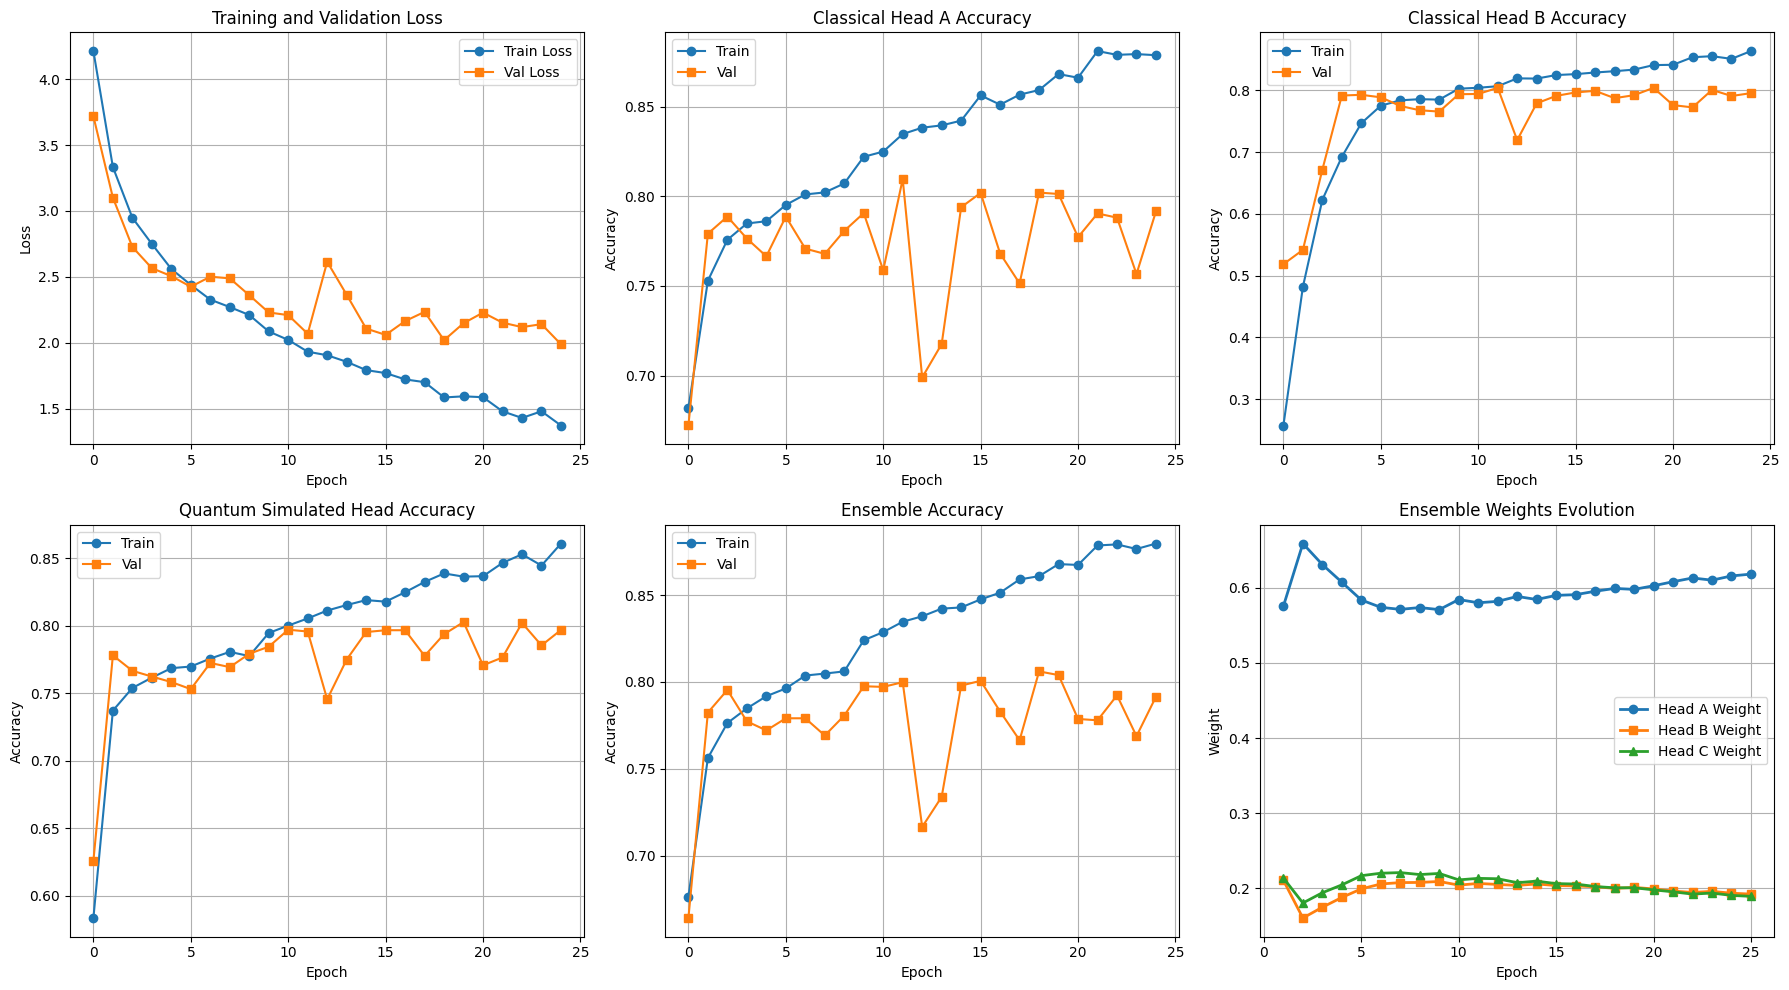


💾 Saving model and extracting features...


📤 Extracting val features: 100%|██████████| 23/23 [00:08<00:00,  2.73it/s]



📊 Extracted Features:
  🚂 Train: (2930, 30) samples, 30 features
  🧪 Validation: (732, 30) samples

⚖️ Current Ensemble Weights: [0.41269597 0.29665914 0.29064488]
✅ Saved classical model to: phase1_classical_model.pth
✅ Saved model info to: model_info.pkl
✅ Saved compressed features to: quantum_training_data.pkl
✅ Saved complete checkpoint to: complete_checkpoint.pth

🎉 PHASE 1 COMPLETED SUCCESSFULLY

🏆 Final Ensemble Weights:
  🎯 Classical Head A: 0.618
  🎯 Classical Head B: 0.192
  ⚛️ Quantum Head:     0.189

📥 DOWNLOADING FILES FOR LOCAL DEPLOYMENT
⬇️ Downloading phase1_classical_model.pth...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

⬇️ Downloading quantum_training_data.pkl...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

⬇️ Downloading model_info.pkl...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

⬇️ Downloading complete_checkpoint.pth...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


🎯 COLAB TRAINING COMPLETE

📋 Next steps:
1. 📁 Create 'trained_model' folder in VS Code project
2. 📥 Copy downloaded files to 'trained_model' folder
3. 🚀 Run: streamlit run streamlit_app.py


In [ ]:
# ============================================================================
# SECTION 8: EXECUTE TRAINING
# ============================================================================
print("=" * 70)
print("👁️ DIABETIC RETINOPATHY CLASSIFICATION PIPELINE")
print("=" * 70)

print("\n" + "=" * 70)
print("🚀 STARTING PHASE 1: Hybrid Classical-Quantum Training")
print("=" * 70)

classical_model, trainer, history, save_dict = train_phase1()

print("\n" + "=" * 70)
print("🎉 PHASE 1 COMPLETED SUCCESSFULLY")
print("=" * 70)

if history and 'ensemble_weights' in history and history['ensemble_weights']:
    final_weights = history['ensemble_weights'][-1]
    print(f"\n🏆 Final Ensemble Weights:")
    print(f"  🎯 Classical Head A: {final_weights[0]:.3f}")
    print(f"  🎯 Classical Head B: {final_weights[1]:.3f}")
    print(f"  ⚛️ Quantum Head:     {final_weights[2]:.3f}")

from google.colab import files

files_to_download = [
    'phase1_classical_model.pth',
    'quantum_training_data.pkl',
    'model_info.pkl',
    'complete_checkpoint.pth'
 ]

print("\n" + "=" * 70)
print("📥 DOWNLOADING FILES FOR LOCAL DEPLOYMENT")
print("=" * 70)

for file in files_to_download:
    if os.path.exists(file):
        print(f"⬇️ Downloading {file}...")
        files.download(file)
    else:
        print(f"⚠️ Warning: {file} not found")

print("\n" + "=" * 70)
print("🎯 COLAB TRAINING COMPLETE")
print("=" * 70)
print("\n📋 Next steps:")
print("1. 📁 Create 'trained_model' folder in VS Code project")
print("2. 📥 Copy downloaded files to 'trained_model' folder")
print("3. 🚀 Run: streamlit run streamlit_app.py")